# Homework 4

## References

+ Lectures 13-16 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [640]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

from matplotlib import rc
rc('text', usetex=True)

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

Additional functions used to keep code clean and concise for repeat tasks:

In [641]:
def plot_posterior_predictive(
    model,
    xx,
    phi,
    x,
    y
):
    """Plot the posterior predictive separating
    aleatory and espitemic uncertainty.
    
    Arguments:
    model    -- A trained model.
    xx       -- The points on which to evaluate
                the posterior predictive.
    phi      -- The design matrix for the input data
    x        -- The observed data x-coordinates
    y        -- The observed data y-coordinates
    """
    # make prediction using model
    yy_mean, yy_measured_std = model.predict(
        phi,
        return_std=True
    )
    # determine the noise standard deviation internal to function
    sigma = np.sqrt(1.0 / model.alpha_)
    # Extract epistemic predictive standard deviation
    yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
    # Epistemic 95% credible interval
    yy_le = yy_mean - 2.0 * yy_std
    yy_ue = yy_mean + 2.0 * yy_std
    # Epistemic + aleatory 95% credible interval
    yy_lae = yy_mean - 2.0 * yy_measured_std
    yy_uae = yy_mean + 2.0 * yy_measured_std
    # Plot
    fig, ax = plt.subplots()
    ax.plot(xx, yy_mean, 'r', label="Posterior Mean")
    ax.fill_between(
        xx,
        yy_le,
        yy_ue,
        color='red',
        alpha=0.25,
        label="95\% Epistemic C.I."
    )
    ax.fill_between(
        xx,
        yy_lae,
        yy_le,
        color='green',
        alpha=0.25
    )
    ax.fill_between(
        xx,
        yy_ue,
        yy_uae,
        color='green',
        alpha=0.25,
        label="95\% Epistemic + Aleatory C.I."
    )
    ax.plot(x, y, 'kx', label='Observed Data')
    ax.set_xlabel('$\epsilon$ (strain in \%)')
    ax.set_ylabel('$\sigma$ (stress in MPa)')
    ax.set_title("Epistemic \& Aleatory Uncertainty About Mean Posterior Prediction")
    plt.legend(loc="best");
    # reference(s): hands-on activity 15.1

In [642]:
def perform_diagnostics(
    x_train,
    x_valid,
    y_train,
    y_valid,
    Phi_valid,
    model
):
    """Perform diagnostics on a particular model using:
    mean squared error, an observations vs. predictions plot,
    a standardized errors plot, and a quantile-quantile plot
    
    Arguments:
    x_train   -- The x-coordinates of the training data
    x_valid   -- The x-coordinates of the validation data
    y_train   -- The y-coordinates of the training data
    y_valid   -- The y-coordinates of the validation data
    Phi_valid -- The design matrix for the validation data
    model     -- A preconstructed model object from sklearn
    """
    # make prediction using model
    y_valid_mean_p, y_valid_std_p = model.predict(
        Phi_valid,
        return_std=True
    )
    # compute MSE
    MSE = np.mean((y_valid_mean_p - y_valid)**2)
    print(f"Mean Squared Error (MSE) = {MSE:.2f}")
    
    # # Observations vs. Predictions
    fig, ax = plt.subplots()
    ax.plot(y_valid_mean_p, y_valid, 'o')
    yys = np.linspace(y_valid.min(), y_valid.max(), 100)
    ax.plot(yys, yys, 'r-');
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Observations')
    ax.set_title("Observations vs. Predictions");
    
    # Standardized Errors
    eps = (y_valid - y_valid_mean_p) / y_valid_std_p
    idx = np.arange(1, eps.shape[0] + 1)

    fig, ax = plt.subplots()
    ax.plot(idx, eps, 'o', label='Standarized errors')
    ax.plot(idx, 1.96 * np.ones(eps.shape[0]), 'r--')
    ax.plot(idx, -1.96 * np.ones(eps.shape[0]), 'r--')
    ax.set_xlabel('$i$')
    ax.set_ylabel('$\epsilon_i$')
    ax.set_title("Standardized Errors");
    
    # Quantile-Quantile
    fig, ax = plt.subplots()
    st.probplot(eps, dist=st.norm, plot=ax);
    # reference(s): hands-on activities 13.4, 15.3

In [643]:
def analyze_alpha(
    model
):
    """Perform a brief analysis to determine which basis functions from
    the input model are the most important for making predictions
    
    Arguments:
    model     -- A preconstructed model object from sklearn
    """
    # extract hyperparameter alpha
    alpha = model.lambda_
    print('alpha = ')
    print(alpha)
    # generate bar plot to visualize the alpha values on a log scale
    fig, ax = plt.subplots()
    ax.bar(range(len(alpha)), alpha)
    ax.set_xlabel('Feature id $j$')
    ax.set_ylabel(r'$\alpha_j$')
    ax.set_yscale("log")
    ax.set_title("Visualizing the Weight Precisions");
    # reference(s): hands-on activity 15.2
    
    # sorting the alpha values and their order in the polynomial
    sorted_idx = np.array(
        [
            i for i in range(0,len(alpha))
        ]
    )
    sorted_alpha = alpha
    for n in range(len(sorted_alpha)):
        for i in range(len(sorted_alpha)-1):
            if sorted_alpha[i] > sorted_alpha[i+1]:
                # temporary variables
                temp1 = sorted_alpha[i]
                temp2 = sorted_idx[i]
                # perform element swap
                sorted_alpha[i] = sorted_alpha[i+1]
                sorted_idx[i] = sorted_idx[i+1]
                sorted_alpha[i+1] = temp1
                sorted_idx[i+1] = temp2
    # displaying the results
    print("Sorted alpha values: ")
    print(sorted_alpha)
    print("Sorted alpha indices: ")
    print(sorted_idx)
    # reference(s): hands-on activity 15.2

## Student details

+ **First Name:** Jack
+ **Last Name:** Girard
+ **Email:** girard2@purdue.edu

# Problem 1 - Estimating the mechanical properties of a plastic material from molecular dynamics simulations

First, make sure that [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/stress_strain.txt) dataset is visible from this Jupyter notebook.
You may achieve this by either:

+ Downloading the data file, and then mannually upload it on Google Colab. The easiest way is to click on the folder icon on the left of the browser window and click on the upload button (or just drag and drop the file). Some other options are [here](https://colab.research.google.com/notebooks/io.ipynb).
+ Downloading the file to the working directory of this notebook with this code:

In [644]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/stress_strain.txt"
download(url)

It's up to you what you choose to do.
If the file is in the right place, the following code should work:

In [645]:
data =  np.loadtxt('stress_strain.txt')

The dataset was generated using a molecular dynamics simulation of a plastic material (thanks to [Professor Alejandro Strachan](https://engineering.purdue.edu/MSE/people/ptProfile?id=33239) for sharing the data!).
Specifically, Strachan's group did the following:
- They took a rectangular chunk of the material and marked the position of each one of its atoms;
- They started applying a tensile force along one dimension.
The atoms are coupled together through electromagnetic forces and they must all satisfy Newton's law of motion.
- For each value of the applied tensile force they marked the stress (force be unit area) in the middle of the materail and the corresponding strain of the material (percent enlogation in the pulling direction).
- Eventually the material entered the plastic regime and then it broke.
Here is a visualization of the data:

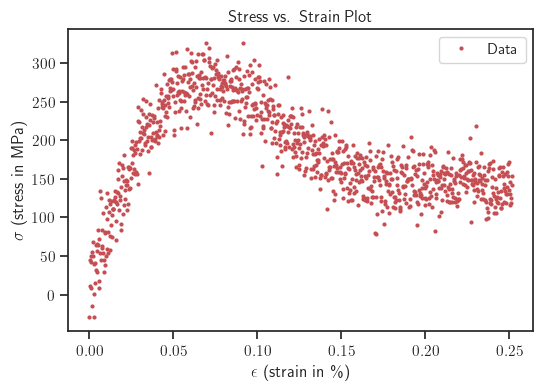

In [646]:
# Strain 
x = data[:, 0]
# Stress in MPa
y = data[:, 1]
plt.figure()
plt.plot(
    x,
    y,
    'ro',
    markersize=2,
    label='Data'
)
plt.xlabel('$\epsilon$ (strain in \%)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.title("Stress vs. Strain Plot")
plt.legend(loc='best');

Note that for each particular value of the strain, you don't necessarily get a unique stress.
This is because in molecular dynamics the atoms are jiggling around due to thermal effects.
So there is always this "jiggling" noise when you are trying to measure the stress and the strain.
We would like to process this noise in order to extract what is known as the [stress-strain curve](https://en.wikipedia.org/wiki/Stress–strain_curve) of the material.
The stress-strain curve is a macroscopic property of the the material which is affeted by the fine structure, e.g., the chemical bonds, the crystaline structure, any defects, etc.
It is a required input to mechanics of materials.

## Part A - Fitting the stress-strain curve in the elastic regime
The very first part of the stress-strain curve should be linear.
It is called the *elastic regime*.
In that region, say $\epsilon < \epsilon_l=0.04$, the relationship between stress and strain is:

$$
\sigma(\epsilon) = E\epsilon.
$$

The constant $E$ is known as the *Young modulus* of the material.
Assume that you measure $\epsilon$ without any noise, but your measured $\sigma$ is noisy.

### Subpart A.I
First, extract the relevant data for this problem, split it into training and validation datasets, and visualize the training and validation datasets using different colors.

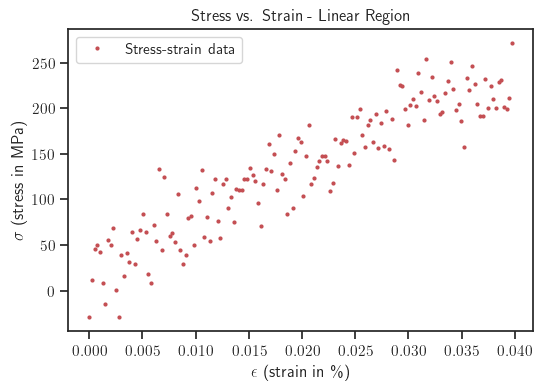

In [647]:
# The point at which the stress-strain curve stops being linear
epsilon_l = 0.04
# Relevant data (this is nice way to get the linear part of the stresses and straints)
x_rel = x[x < 0.04]
y_rel = y[x < 0.04]

# Visualize to make sure you have the right data
plt.figure()
plt.plot(
    x_rel,
    y_rel,
    'ro',
    markersize=2,
    label='Stress-strain data'
)
plt.xlabel('$\epsilon$ (strain in \%)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.title("Stress vs. Strain - Linear Region")
plt.legend(loc='best');

Split your data into training and validation.

**Hint:** You may use [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) if you wish.

In [648]:
# read-in necessary item from sklearn package
from sklearn.model_selection import train_test_split
# splitting the data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_rel, y_rel, test_size=0.3, shuffle=True
)
# defining variables according to how many total, training, and validation features there are
numRelevant = x_rel.shape[0]
numTrain = x_train.shape[0]
numValid = x_valid.shape[0]
print("Number of relevant data points (in linear region): ", numRelevant)
print("Number of training data points: ", numTrain)
print("Number of validation data points: ", numValid)

Number of relevant data points (in linear region):  159
Number of training data points:  111
Number of validation data points:  48


Use the following to visualize your split:

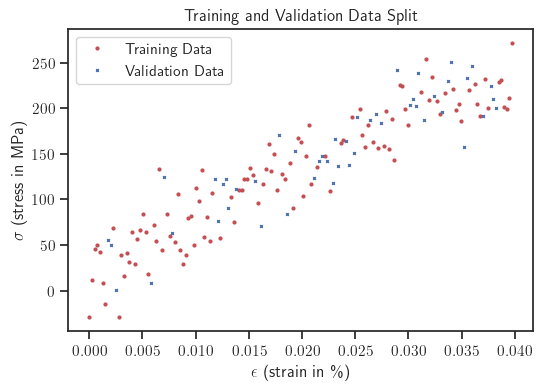

In [649]:
plt.figure()
plt.plot(
    x_train,
    y_train,
    'ro',
    markersize=2,
    label='Training Data'
)
plt.plot(
    x_valid,
    y_valid,
    'bx',
    markersize=2,
    label='Validation Data'
)
plt.xlabel('$\epsilon$ (strain in \%)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.title("Training and Validation Data Split")
plt.legend(loc='best');

### Subpart A.II
Perform Bayesian linear regression with the evidence approximation to estimate the noise variance and the hyperparameters of the prior.

As indicated previously, the relationship between stress and strain is linear:

$$
\sigma(\epsilon) = E\epsilon.
$$

The stress values, $\sigma$, are the targets and the strain values, $\epsilon$, are the features. The generalized linear model is:

$$
y(\mathbf{x};\mathbf{w}) = \sum_{j=1}^{m} w_{j}\phi_{j}(\mathbf{x}) = \mathbf{w^{T}\boldsymbol{\phi}(\mathbf{x})}
$$

In this situation, we have $m = 2$ basis functions. Since we will be using polynomials, the linear model simplifies to:

$$
y(\mathbf{x};\mathbf{w}) = \sum_{j=1}^{2} w_{j}\phi_{j}(\mathbf{x}) = w_{1}\phi_{1}(\mathbf{x}) + w_{2}\phi_{2}(\mathbf{x})
$$

where $\phi_{1}(\epsilon) = 1$ and $\phi_{2}(\epsilon) = \epsilon$. Substituting our model parameters, this expression becomes:

$$
\sigma(\epsilon;\mathbf{w}) = w_{1} + w_{2}\phi_{2}(\epsilon)
$$

However, it is assumed that when $\epsilon = 0$, then $\sigma = 0$ as well. This implies that $w_{1} = 0$. The above expression further simplifies to:

$$
\sigma(\epsilon;w_{2}) = w_{2}\phi_{2}(\epsilon) = w_{2}\epsilon
$$

and the objective is to determine $w_{2}$. We will want a design matrix corresponding to a fit of degree 1 and y-intercept of 0.

In [650]:
# read-in necessary item from sklearn package
from sklearn.linear_model import BayesianRidge
# design matrix
Phi_train = x_train.reshape(-1, 1)
# fit model
model = BayesianRidge(
    fit_intercept=False
).fit(Phi_train, y_train)
# extract noise standard deviation
sigma = np.sqrt(1.0 / model.alpha_)
print(f'Noise standard deviation: sigma = {sigma:1.2f}')
# extract the noise variance
sigma2 = sigma**2
print(f'Noise variance:           sigma2 = {sigma2:1.2f}')
# extract hyperparameter alpha
alpha = model.lambda_
print(f'Hyperparameter of prior:  alpha = {alpha}')
# reference(s): hands-on activities 13.3, 15.1

Noise standard deviation: sigma = 29.19
Noise variance:           sigma2 = 851.84
Hyperparameter of prior:  alpha = 2.4172963099379953e-08


### Subpart A.III
Calculate the mean square error of the validation data.

In [651]:
# design matrix for validation features
Phi_valid = x_valid.reshape(-1, 1)
# make prediction on validation features with model
y_valid_mean_p, y_valid_std_p = model.predict(
    Phi_valid,
    return_std=True
)
# compute and display MSE
MSE = np.mean((y_valid_mean_p - y_valid)**2)
print(f"Mean Squared Error (MSE) = {MSE:.2f}")
# reference(s): hands-on activity 13.4

Mean Squared Error (MSE) = 925.25


### Subpart A.IV
Make the observations vs predictions plot for the validation data.

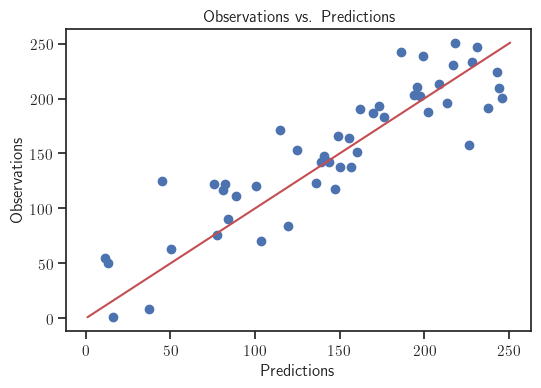

In [652]:
fig, ax = plt.subplots()
ax.plot(y_valid_mean_p, y_valid, 'o')
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
ax.set_title("Observations vs. Predictions");
# reference(s): hands-on activity 15.3

### Subpart A.V
Compute and plot the standarized errors for the validation data.

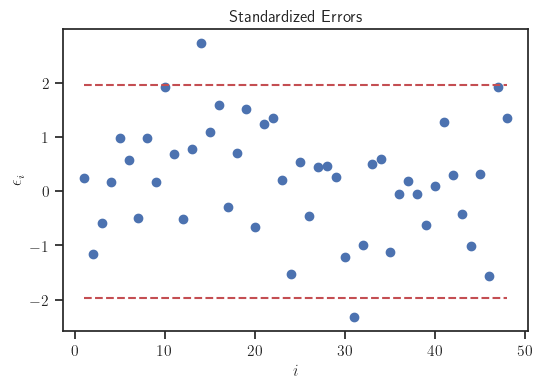

In [653]:
# compute standardized errors
eps = (y_valid - y_valid_mean_p) / y_valid_std_p
# plotting result
idx = np.arange(1, eps.shape[0] + 1)
fig, ax = plt.subplots()
ax.plot(idx, eps, 'o', label='Standarized errors')
ax.plot(idx, 1.96 * np.ones(eps.shape[0]), 'r--')
ax.plot(idx, -1.96 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$')
ax.set_title("Standardized Errors");
# reference(s): hands-on activity 15.3

### Subpart A.VI
Make the quantile-quantile plot of the standarized errors.

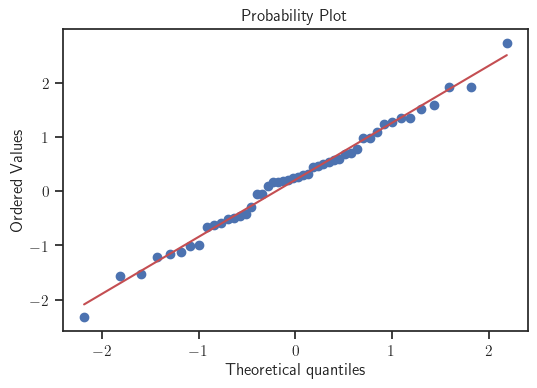

In [654]:
fig, ax = plt.subplots()
st.probplot(eps, dist=st.norm, plot=ax);
# reference(s): hands-on activity 15.3

### Subpart A.VII
Visualize your epistemic and the aleatory uncertainty about the stress-strain curve in the elastic regime.

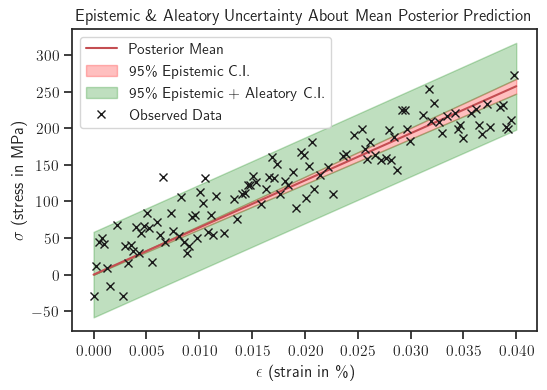

In [655]:
# define array of epsilon values to plot against
xx = np.linspace(0.0, epsilon_l, 100)
# call to function for plotting posterior predictive
plot_posterior_predictive(
    model,
    xx,
    xx[:, None],
    x_train,
    y_train
)

### Subpart A. VIII
Visualize the posterior of the Young modulus E conditioned on the data.

Posterior mean of weights: [6430.612]
Posterior covariance of weights:
[[15848.246]]


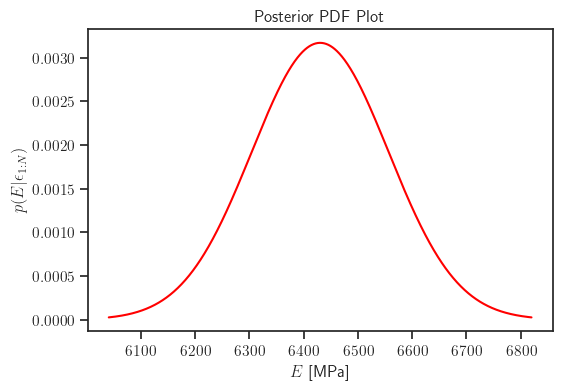

In [656]:
# posterior mean of the weights
m_post = model.coef_
print(f"Posterior mean of weights: {m_post}")
# posterior covariance of the weights
S_post = model.sigma_
print(f"Posterior covariance of weights:")
print(S_post)
# define the posterior distribution & plot
E_post = st.norm(loc=m_post[0], scale=np.sqrt(S_post[0, 0]))
es = np.linspace(E_post.ppf(0.001), E_post.ppf(0.999), 1000)
fig, ax = plt.subplots()
ax.plot(es, E_post.pdf(es), color='red')
ax.set_xlabel('$E$' + ' [MPa]')
ax.set_ylabel('$p(E|\epsilon_{1:N})$')
ax.set_title('Posterior PDF Plot');
# reference(s): hands-on activities 14.3, 15.1

### Subpart A.IX
Take five samples of stress-strain curve in the elastic regime and visualize them.

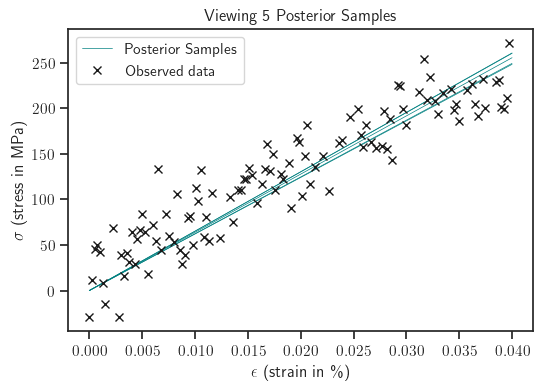

In [657]:
fig, ax = plt.subplots()
numSamples = 5
for _ in range(numSamples):
    E_sample = E_post.rvs()
    yy_sample = E_sample*xx
    ax.plot(xx, yy_sample, color='teal', lw=0.5)
ax.plot([], [], color='teal', lw=0.5, label="Posterior Samples")
ax.plot(x_train, y_train, 'kx', label='Observed data')
ax.set_xlabel('$\epsilon$ (strain in \%)')
ax.set_ylabel('$\sigma$ (stress in MPa)')
ax.set_title("Viewing 5 Posterior Samples")
plt.legend(loc="best");
# reference(s): hands-on activity 15.1

### Subpart A.X

Find the 95% centered credible interval for the Young modulus $E$.

E is in [6183.87, 6677.35] with 95% probability


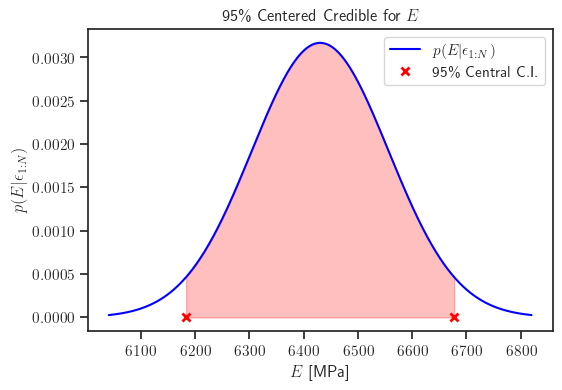

In [658]:
# determine quantile values
E_low = E_post.ppf(0.025)
E_up = E_post.ppf(0.975)
print(f'E is in [{E_low:.2f}, {E_up:1.2f}] with 95% probability')
# plotting the credible interval with the posterior
fig, ax = plt.subplots()
ax.plot(es, E_post.pdf(es), color='blue', label='$p(E|\epsilon_{1:N})$')
es_int = np.linspace(E_low, E_up, 100)
ax.fill_between(
    es_int,
    np.zeros(es_int.shape),
    E_post.pdf(es_int),
    color='red',
    alpha=0.25
)
ax.plot(
    [E_low, E_up],
    np.zeros((2,)),
    'x',
    color='red',
    markeredgewidth=2,
    label='95\% Central C.I.'
)
ax.set_xlabel('$E$' + ' [MPa]')
ax.set_ylabel('$p(E|\epsilon_{1:N})$')
ax.set_title("95\% Centered Credible for $E$")
plt.legend(loc="best");
# reference(s): hands-on activity 12.2

### Subpart A.XI
If you had to pick a single value for the Young modulus $E$, what would it be and why?

In [659]:
# calculate and display different selections for E
E_min01Loss = es[np.argmax(E_post.pdf(es))]
print(f"Choice for E that minimizes the 0-1 loss: {E_min01Loss:.2f}")
E_minSquareLoss = E_post.mean()
print(f"Choice for E that minimizes the square loss: {E_minSquareLoss:.2f}")
E_minAbsoluteLoss = E_post.median()
print(f"Choice for E that minimizes the absolute loss: {E_minAbsoluteLoss:.2f}")
print("Choose E* to be:")
print(f"E* = {E_minSquareLoss:.0f} MPa")
# reference(s): hands-on activity 12.3

Choice for E that minimizes the 0-1 loss: 6430.22
Choice for E that minimizes the square loss: 6430.61
Choice for E that minimizes the absolute loss: 6430.61
Choose E* to be:
E* = 6431 MPa


**Subpart A.XI Discussion:**

In this case, because the posterior $p(E|\epsilon_{1:N})$ takes on the form of a Gaussian, the selections for $E$ that minimize the 0-1 loss, square loss, and absolute loss are the same value. In other words the mode, mean, and median value for $E$ according to $p(E|\epsilon_{1:N})$ are the same. This particular value that minimizes the three losses, $E^{*}$, was selected.

Of course, the best selection for $E^{*}$ is subjective. Depending on details of the application and goals of the analysis, there may be an argument for selecting a different value for $E^{*}$.

## Part B - Estimate the ultimate strength

The pick of the stress-strain curve is known as the ultimate strength.
We will like to estimate it.

### Subpart B.I - Extract training and validation data

Extract training and validation data from the entire dataset.

In [660]:
# splitting the data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x, y, test_size=0.3, shuffle=True
)
# defining variables according to how many total, training, and validation features there are
numTotal = x.shape[0]
numTrain = x_train.shape[0]
numValid = x_valid.shape[0]
print("Number of total data points: ", numTotal)
print("Number of training data points: ", numTrain)
print("Number of validation data points: ", numValid)

Number of total data points:  1001
Number of training data points:  700
Number of validation data points:  301


Use the following to visualize your split:

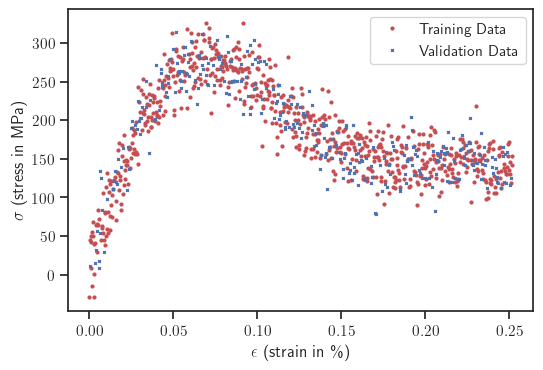

In [661]:
plt.figure()
plt.plot(
    x_train,
    y_train,
    'ro',
    markersize=2,
    label='Training Data'
)
plt.plot(
    x_valid,
    y_valid,
    'bx',
    markersize=2,
    label='Validation Data'
)
plt.xlabel('$\epsilon$ (strain in \%)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best');

### Subpart B.II - Model the entire stress-strain relationship.
To do this, we will set up a generalized linear model that can capture the entire stress-strain relationship.
Remember, you can use any model you want as soon as:
+ it is linear in the parameters to be estimated,
+ it clearly has a well-defined elastic regime (see Part A).

I am going to help you set up the right model.
We are goint to use the [Heavide step function](https://en.wikipedia.org/wiki/Heaviside_step_function) to turn on or off models for various ranges of $\epsilon$. The idea is quite simple: We will use a linear model for the elastic regime and we are going to turn to a non-linear model for the non-linear regime.
Here is a model that has the right form in the elastic regime and an arbitrary form in the non-linear regime:

$$
f(\epsilon;E,\mathbf{w}_g) = E\epsilon \left[(1 - H(\epsilon - \epsilon_l)\right] + g(\epsilon;\mathbf{w}_g)H(\epsilon - \epsilon_l),
$$

where

$$
H(x) = \begin{cases}
0,\;\text{if}\;x < 0\\
1,\;\text{otherwise},
\end{cases}
$$

and $g$ is any function linear in the parameters $\mathbf{w}_g$.

You can use any model you like for the non-linear regime, but let's use a polynomial of degree $d$:

$$
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i.
$$

The full model can be expressed as:

$$
\begin{split}
f(\epsilon) &= 
\begin{cases}
h(\epsilon) = E \epsilon,\ \epsilon < \epsilon_l, \\
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i, \epsilon \geq \epsilon_l
\end{cases}\\
&= E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
\end{split}
$$

We could proceed with this model, but there is a small problem: It is discontinuous at $\epsilon = \epsilon_l$.
This is unphysical. We can do better than that!

To make the model nice, we force the $h$ and $g$ to match up to the first derivative, i.e., we demand that:

$$
\begin{split}
h(\epsilon_l) &= g(\epsilon_l)\\
h'(\epsilon_l) &= g'(\epsilon_l).
\end{split}
$$

The reason we include the first derivative is so that we don't have a kink in the stress-strain. That would also be unphysical.
The two equations above become:

$$
\begin{split}
E\epsilon_l &= \sum_{i=0}^dw_i\epsilon_l^i\\
E &= \sum_{i=1}^diw_i\epsilon_l^{i-1}.
\end{split}
$$

We can use these two equations to eliminate two weights.
Let's eliminate $w_0$ and $w_1$.
All you have to do is express them in terms of $E$ and $w_2,\dots,w_d$.
So, there remain $d$ parameters to estimate.
Let's get back to the stress-strain model.

Our stress-strain model was:

$$
f(\epsilon) = E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
$$

We can now use the expressions for $w_0$ and $w_1$ to rewrite this using only all the other 
parameters.
I am going to spare you the details...
The end result is:

$$
f(\epsilon) = E\epsilon + \sum_{i=2}^dw_i\left[(i-1)\epsilon_{l}^{i} - i \epsilon \epsilon_{l}^{i-1} + \epsilon^i\right]H(\epsilon - \epsilon_l).
$$

Okay.
This is still a generalized linear model. This is nice.
Write code for the design matrix:

In [662]:
# Complete this code to make your model:
def compute_design_matrix(Epsilon, epsilon_l, d):
    """Compute the design matrix for the stress-strain curve problem.
    
    Arguments:
        Epsilon     -     A 1D array of dimension N.
        epsilon_l   -     The strain signifying the end of the elastic regime.
        d           -     The polynomial degree.
    
    Returns:
        A design matrix N x d
    """
    # Sanity check
    assert isinstance(Epsilon, np.ndarray)
    assert Epsilon.ndim == 1, 'Pass the array as epsilon.flatten(), if it is two dimensional'
    n = Epsilon.shape[0]
    # The design matrix:
    Phi = np.ndarray((n, d))
    # The step function evaluated at all the elements of Epsilon.
    # You can use it if you want.
    Step = np.ones(n)
    Step[Epsilon < epsilon_l] = 0
    # Build the design matrix
    Phi[:, 0] = Epsilon
    for i in range(2, d+1):
        Phi[:, i-1] = ((i-1)*epsilon_l**i - 
                       i*Epsilon*epsilon_l**(i-1) + 
                       Epsilon**i) * Step
    return Phi

Visualize the basis functions here:

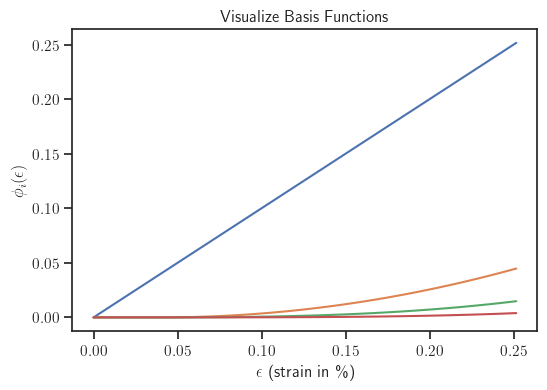

In [663]:
d = 4
eps = np.linspace(0, x.max(), 100)
Phis = compute_design_matrix(eps, epsilon_l, d)
fig, ax = plt.subplots(dpi=100)
ax.plot(eps, Phis)
ax.set_xlabel('$\epsilon$ (strain in \%)')
ax.set_ylabel('$\phi_i(\epsilon)$')
ax.set_title("Visualize Basis Functions");

### Subpart B.III 

Fit the model using automatic relevance determination and demonstrate that it works well by doing all the things we did above (MSE, observations vs predictions plot, standarized errors, etc.).

In [664]:
# read-in necessary item from sklearn package
from sklearn.linear_model import ARDRegression
# generate design matrix corresponding to the training data
Phi_train = compute_design_matrix(x_train, epsilon_l, d)
# generate model
model = ARDRegression(
    fit_intercept=False,
    threshold_lambda=np.inf
).fit(Phi_train, y_train)
# reference(s): hands-on activity 15.2

Mean Squared Error (MSE) = 751.72


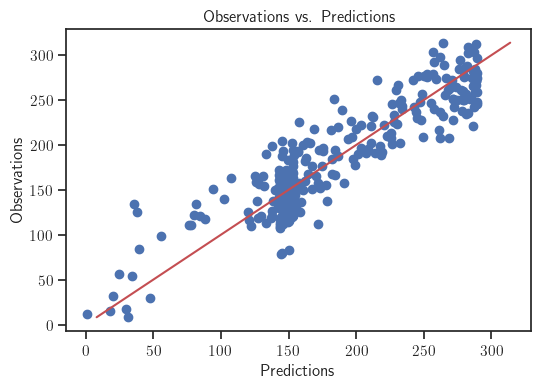

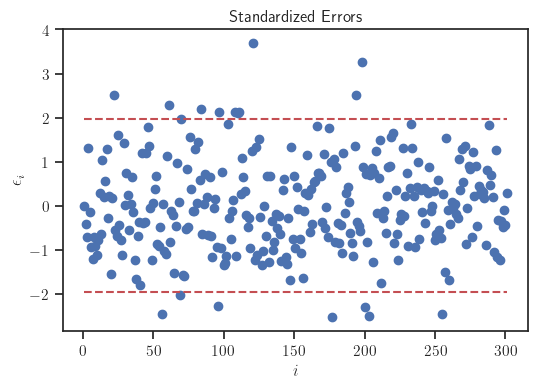

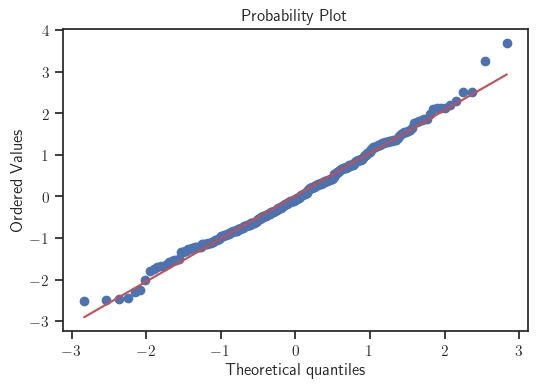

In [665]:
# generate design matrix corresponding to the validation data
Phi_valid = compute_design_matrix(x_valid, epsilon_l, d)
# performing diagnostics using function
perform_diagnostics(
    x_train,
    x_valid,
    y_train,
    y_valid,
    Phi_valid,
    model
)

### Subpart B.IV
Visualize epistemic and aleatory uncertainty in the stess-strain relation.

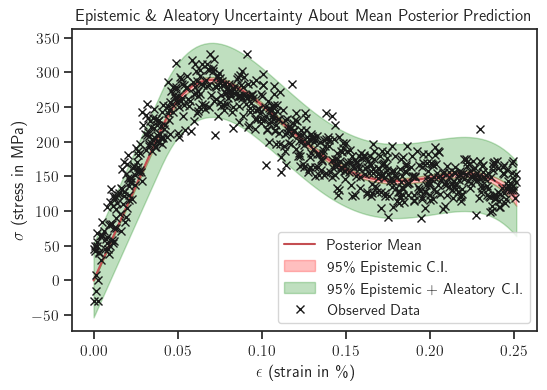

In [666]:
# define array of epsilon values to plot against
xx = np.linspace(0.0, x.max(), 100)
# compute design matrix using function defined above in this section
Phi_xx = compute_design_matrix(xx, epsilon_l, d)
# call to function for plotting posterior predictive
plot_posterior_predictive(
    model,
    xx,
    Phi_xx,
    x_train,
    y_train
)

### Subpart B.V - Extract the ultimate strength

Now, you are going to quantify your epistemic uncertainty about the ultimate strength.
The ultimate strength is the maximum of the stress-strain relationship.
Since you have epistemic uncertainty about the stress-strain relationship, you also have epistemic uncertainty about the ultimate strength.

Do the following:
- Visualize posterior of the ultimate strength.
- Find a 95% credible interval for the ultimate strength.
- Pick a value for the ultimate strength.

**Hint:**
To characterize your epistemic uncertainty about the ultimate strength, you would have to do the following:
- Define a dense set of strain points between 0 and 0.25.
- Repeatedly:
    + sample from the posterior of the weights of your model
    + for each sample evaluate the stresses at the dense set of strain points defined earlier
    + for each sampled stress vector, find the maximum. This is a sample of the ultimate strength.

Sigma_ut is in [285.18, 292.95] with 95% probability
Choose sigma_ut* to be:
sigma_ut* = 289.06 MPa


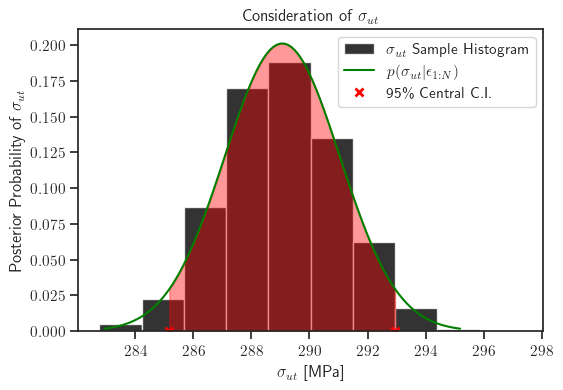

In [667]:
# posterior mean of the weights
m_post = model.coef_
# posterior variance of the weights
S_post = model.sigma_
# define the posterior distribution
w_post = st.multivariate_normal(mean=m_post, cov=S_post)
# define number of samples to take
numSamples = 2500
# initialize array to store ultimate tensile strength values
uts_samples = np.zeros((numSamples, 1))
# define dense set of strain points
x_dense = np.linspace(0.0, x.max(), 1000)
# define a design matrix for the dense set of strain points
Phi_dense = compute_design_matrix(x_dense, epsilon_l, d)

# repeatedly:
for i in range(numSamples):
    # sample from the posterior of the weights
    w_sample = w_post.rvs()
    # evaluate the stresses at the dense set of strain points
    yy_sample = np.dot(Phi_dense, w_sample)
    # determine the maximum of the stress vector
    uts_samples[i] = np.max(yy_sample)
    
# visualize a histogram of the samples
fig, ax = plt.subplots()
ax.hist(uts_samples, density=True, alpha=0.8,
        color="black", label="$\sigma_{ut}$" + " Sample Histogram")

# compute and plot theoretical normal
mu = np.mean(uts_samples)
var = np.var(uts_samples)
postTheoretical = st.norm(loc=mu, scale=np.sqrt(var))
xs = np.linspace(postTheoretical.ppf(0.001), postTheoretical.ppf(0.999), 100)
ax.plot(xs, postTheoretical.pdf(xs), color='green',
        label="$p(\sigma_{ut}|\epsilon_{1:N})$")

# plot the 95% credible interval
sig_low = postTheoretical.ppf(0.025)
sig_up = postTheoretical.ppf(0.975)
print(f'Sigma_ut is in [{sig_low:.2f}, {sig_up:1.2f}] with 95% probability')
xs_int = np.linspace(sig_low, sig_up, 100)
ax.fill_between(
    xs_int,
    np.zeros(xs_int.shape),
    postTheoretical.pdf(xs_int),
    color='red',
    alpha=0.4
)
ax.plot(
    [sig_low, sig_up],
    np.zeros((2,)),
    'x',
    color='red',
    markeredgewidth=2,
    label='95\% Central C.I.'
)

print("Choose sigma_ut* to be:")
print(f"sigma_ut* = {postTheoretical.mean():.2f} MPa")

ax.set_xlabel("$\sigma_{ut}$" + " [MPa]")
ax.set_ylabel("Posterior Probability of " + "$\sigma_{ut}$")
ax.set_title("Consideration of " + "$\sigma_{ut}$")
plt.legend(loc="best");
# reference(s): hands-on activities 14.3, 15.2

**Subpart B.V Discussion:**

The posterior $p(\sigma_{ut}|\epsilon_{1:N})$ takes the form of a Gaussian, because the normalized histogram of samples from the posterior fit well within a theoretical Gaussian curve. Similar to Question 1, Part A.XI, the above $\sigma_{ut}^{*}$ was selected because it minimizes the 0-1 loss, square loss, and absolute loss.

Of course, the best selection for $\sigma_{ut}^{*}$ is subjective. Depending on details of the application and goals of the analysis, there may be an argument for selecting a different value for $\sigma_{ut}^{*}$.

# Problem 2 - Optimizing the performance of a compressor

In this problem we are going to need [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/compressor_data.xlsx) dataset. The dataset was kindly provided to us by [Professor Davide Ziviani](https://scholar.google.com/citations?user=gPdAtg0AAAAJ&hl=en).
As before, you can either put it on your Google drive or just download it with the code segment below:

In [668]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/compressor_data.xlsx"
download(url)

Note that this is an Excell file, so we are going to need pandas to read it.
Here is how:

In [669]:
import pandas as pd
data = pd.read_excel('compressor_data.xlsx')
print(data)

    T_e  DT_sh   T_c  DT_sc  T_amb   f  m_dot    m_dot.1  Capacity  Power  \
0   -30      11   25      8     35  60   28.8   8.000000      1557    901   
1   -30      11   30      8     35  60   23.0   6.388889      1201    881   
2   -30      11   35      8     35  60   17.9   4.972222       892    858   
3   -25      11   25      8     35  60   46.4  12.888889      2509   1125   
4   -25      11   30      8     35  60   40.2  11.166667      2098   1122   
..  ...     ...  ...    ...    ...  ..    ...        ...       ...    ...   
60   10      11   45      8     35  60  245.2  68.111111     12057   2525   
61   10      11   50      8     35  60  234.1  65.027778     10939   2740   
62   10      11   55      8     35  60  222.2  61.722222      9819   2929   
63   10      11   60      8     35  60  209.3  58.138889      8697   3091   
64   10      11   65      8     35  60  195.4  54.277778      7575   3223   

    Current   COP  Efficiency  
0       4.4  1.73       0.467  
1       4.0

The data are part of a an experimental study of a variable speed reciprocating compressor.
The experimentalists varied two temperatures $T_e$ and $T_c$ (both in C) and they measured various other quantities.
Our goal is to learn the map between $T_e$ and $T_c$ and measured Capacity and Power (both in W).
First, let's see how you can extract only the relevant data.

In [670]:
# Here is how to extract the T_e and T_c columns and put them in a single numpy array
x = data[['T_e','T_c']].values
print(x)

[[-30  25]
 [-30  30]
 [-30  35]
 [-25  25]
 [-25  30]
 [-25  35]
 [-25  40]
 [-25  45]
 [-20  25]
 [-20  30]
 [-20  35]
 [-20  40]
 [-20  45]
 [-20  50]
 [-15  25]
 [-15  30]
 [-15  35]
 [-15  40]
 [-15  45]
 [-15  50]
 [-15  55]
 [-10  25]
 [-10  30]
 [-10  35]
 [-10  40]
 [-10  45]
 [-10  50]
 [-10  55]
 [-10  60]
 [ -5  25]
 [ -5  30]
 [ -5  35]
 [ -5  40]
 [ -5  45]
 [ -5  50]
 [ -5  55]
 [ -5  60]
 [ -5  65]
 [  0  25]
 [  0  30]
 [  0  35]
 [  0  40]
 [  0  45]
 [  0  50]
 [  0  55]
 [  0  60]
 [  0  65]
 [  5  25]
 [  5  30]
 [  5  35]
 [  5  40]
 [  5  45]
 [  5  50]
 [  5  55]
 [  5  60]
 [  5  65]
 [ 10  25]
 [ 10  30]
 [ 10  35]
 [ 10  40]
 [ 10  45]
 [ 10  50]
 [ 10  55]
 [ 10  60]
 [ 10  65]]


In [671]:
# Here is how to extract the Capacity
y = data['Capacity'].values
print(y)

[ 1557  1201   892  2509  2098  1726  1398  1112  3684  3206  2762  2354
  1981  1647  5100  4547  4019  3520  3050  2612  2206  6777  6137  5516
  4915  4338  3784  3256  2755  8734  7996  7271  6559  5863  5184  4524
  3883  3264 10989 10144  9304  8471  7646  6831  6027  5237  4461 13562
 12599 11633 10668  9704  8743  7786  6835  5891 16472 15380 14279 13171
 12057 10939  9819  8697  7575]


Fit the following multivariate polynomial model to **both the Capacity and the Power**:

$$
y = w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2 + w_6T_c^2 + w_7 T_e^2T_c + w_8T_eT_c^2 + w_9 T_e^3 + w_{10}T_c^3 + \epsilon,
$$

where $\epsilon$ is a Gaussian noise term with unknown variance.

**Hints:**
+ You may use [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to construct the design matrix of your polynomial features. Do not program the design matrix by hand.
+ You should split your data into training and validation and use various validation metrics to make sure that your models make sense.
+ Use [ARD Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html#sklearn.linear_model.ARDRegression) to fit any hyperparameters and the noise.

### Subpart A.I - Fit the Capacity

Please don't just fit blindly. Split in training and test and use all the usual diagnostics.

In [672]:
# read-in necessary item from sklearn package
from sklearn.preprocessing import PolynomialFeatures
# splitting all data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x, y, test_size=0.3
)
# define the degree of polynomial based on given equation
degree = 3
# generate the design matrix for the training data
poly = PolynomialFeatures(degree)
Phi_train = poly.fit_transform(x_train)
# fit model, using no fit_intercept and threshold_lambda arguments
model = ARDRegression().fit(Phi_train, y_train)
# reference(s): hands-on activities 15.2, 15.3, 16.4

Mean Squared Error (MSE) = 7.56


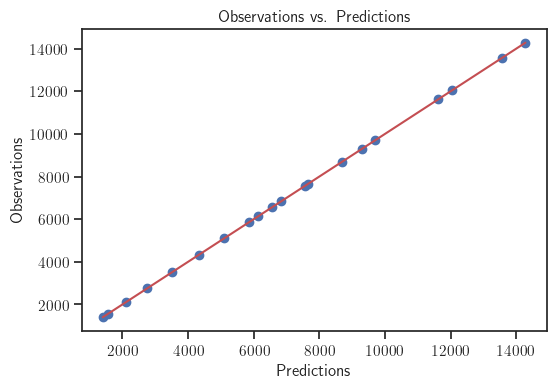

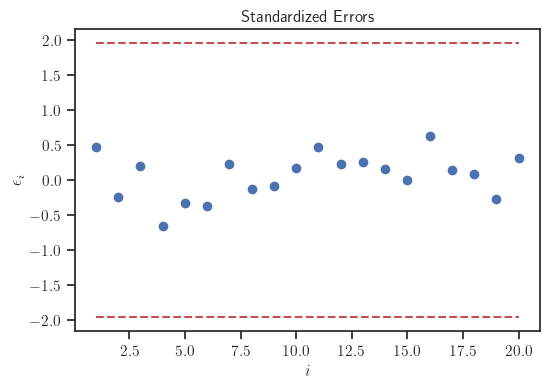

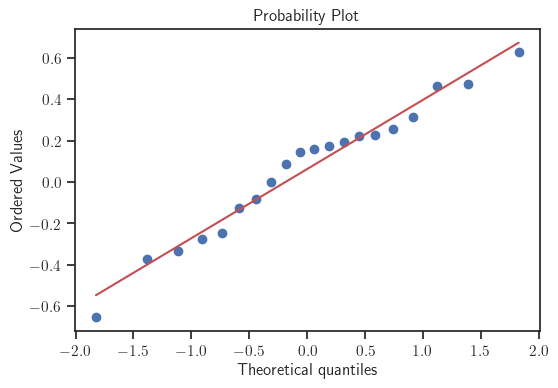

In [673]:
# generate the design matrix for the validation data
Phi_valid = poly.fit_transform(x_valid)
# performing diagnostics using function
perform_diagnostics(
    x_train,
    x_valid,
    y_train,
    y_valid,
    Phi_valid,
    model
)

### Subpart A.II

What is the noise variance you estimated for the Capacity?

In [674]:
sigma = np.sqrt(1.0 / model.alpha_)
print(f'Noise variance for Capacity: sigma2 = {sigma**2:1.2f}')

Noise variance for Capacity: sigma2 = 10.02


### Subpart A.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Capacity?

alpha = 
[1.000e+00 3.016e-06 3.047e-05 1.820e-02 1.066e-01 2.574e+01 1.571e+03
 5.571e+02 1.364e+03 6.483e+04]
Sorted alpha values: 
[3.016e-06 3.047e-05 1.820e-02 1.066e-01 1.000e+00 2.574e+01 5.571e+02
 1.364e+03 1.571e+03 6.483e+04]
Sorted alpha indices: 
[1 2 3 4 0 5 7 8 6 9]


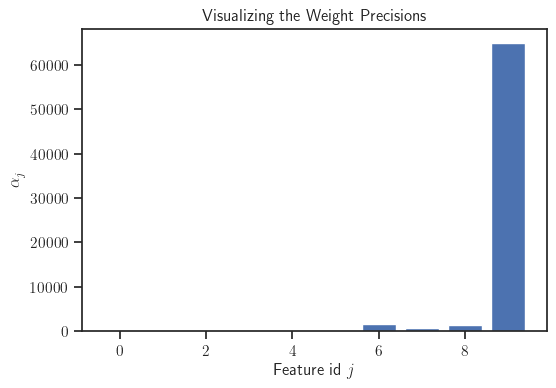

In [675]:
analyze_alpha(model)

**Subpart A.III Discussion:**

The most important basis functions of the model that fits the Capacity correspond to the first 6 weights. See the bar plot above to view the order of importance for the basis functions. The higher the prior precision $\alpha_{j}$ of a weight, the more its prior concentrates about zero (which indicates less importance in the polynomial expression).

### Subpart B.I - Fit the Power

Please don't just fit blindly. Split in training and test and use all the usual diagnostics.

In [248]:
# extracting the Power
y = data['Power'].values
print(y)

[ 901  881  858 1125 1122 1114 1099 1075 1323 1343 1356 1361 1354 1335
 1484 1534 1576 1606 1624 1628 1615 1600 1687 1764 1827 1876 1909 1923
 1917 1663 1794 1911 2014 2101 2169 2217 2243 2246 1663 1844 2010 2159
 2290 2400 2489 2554 2593 1593 1830 2051 2252 2434 2594 2729 2839 2922
 1442 1743 2025 2286 2525 2740 2929 3091 3223]


In [249]:
# read-in necessary item from sklearn package
from sklearn.preprocessing import PolynomialFeatures
# splitting all data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x, y, test_size=0.3, shuffle=True
)
# define the degree of polynomial based on given equation
degree = 3
# generate the design matrix for the training data
poly = PolynomialFeatures(degree)
Phi_train = poly.fit_transform(x_train)
# fit model, using no fit_intercept and threshold_lambda arguments
model = ARDRegression().fit(Phi_train, y_train)
# reference(s): hands-on activities 15.2, 15.3, 16.4

Mean Squared Error (MSE) = 926.80


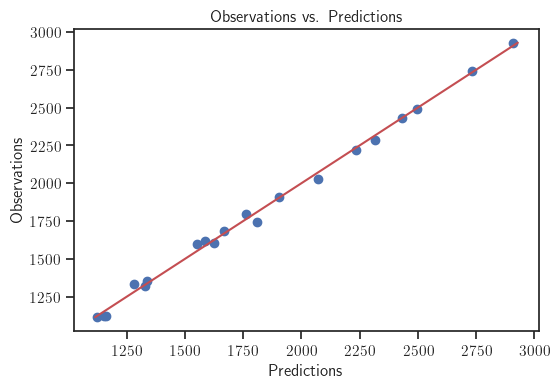

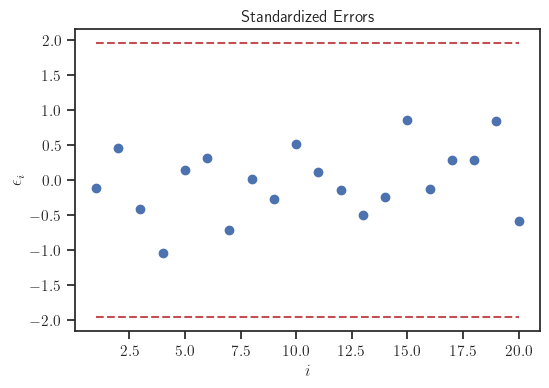

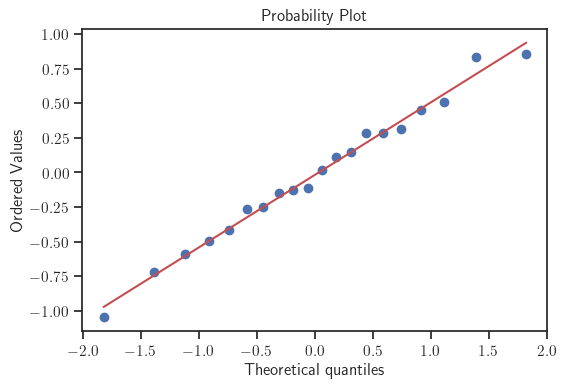

In [250]:
# generate the design matrix for the validation data
Phi_valid = poly.fit_transform(x_valid)
# performing diagnostics using function
perform_diagnostics(
    x_train,
    x_valid,
    y_train,
    y_valid,
    Phi_valid,
    model
)

### Subpart B.II

What is the noise variance you estimated for the Power?

In [251]:
sigma = np.sqrt(1.0 / model.alpha_)
print(f'Noise variance for Power: sigma2 = {sigma**2:1.2f}')

Noise variance for Power: sigma2 = 747.22


### Subpart B.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Power?

alpha = 
[1.000e+00 5.276e-04 2.360e-04 1.613e+00 3.542e-01 5.023e+00 1.257e+04
 1.138e+04 1.010e+04 2.715e+04]
Sorted alpha values: 
[2.360e-04 5.276e-04 3.542e-01 1.000e+00 1.613e+00 5.023e+00 1.010e+04
 1.138e+04 1.257e+04 2.715e+04]
Sorted alpha indices: 
[2 1 4 0 3 5 8 7 6 9]


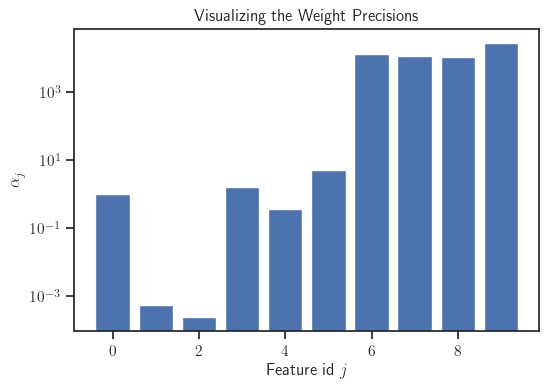

In [252]:
analyze_alpha(model)

**Subpart B.III Discussion:**

The most important basis functions of the model that fits the Power correspond to the first 6 weights. See the bar plot above to view the order of importance for the basis functions. The higher the prior precision $\alpha_{j}$ of a weight, the more its prior concentrates about zero (which indicates less importance in the polynomial expression).

# Problem 3 - Explaining the challenger disaster
On January 28, 1986, the [Space Shuttle Challenger](https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster) disintegrated after 73 seconds from launch.
The failure can be traced on the rubber O-rings which were used to seal the joints of the solid rocket boosters (required to force the hot, high-pressure gases generated by the burning solid propelant through the nozzles thus producing thrust).

It turns out that the performance of the O-ring material was particularly sensitive on the external temperature during launch.
This [dataset](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/challenger_data.csv) contains records of different experiments with O-rings recorded at various times between 1981 and 1986.
Download the data the usual way (either put them on Google drive or run the code cell below).

In [42]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/challenger_data.csv"
download(url)

Even though this is a csv file, you should load it with pandas because it contains some special characters.

In [43]:
raw_data = pd.read_csv('challenger_data.csv')
print(raw_data)

          Date  Temperature      Damage Incident
0   04/12/1981           66                    0
1   11/12/1981           70                    1
2      3/22/82           69                    0
3      6/27/82           80                  NaN
4   01/11/1982           68                    0
5   04/04/1983           67                    0
6      6/18/83           72                    0
7      8/30/83           73                    0
8     11/28/83           70                    0
9   02/03/1984           57                    1
10  04/06/1984           63                    1
11     8/30/84           70                    1
12  10/05/1984           78                    0
13  11/08/1984           67                    0
14     1/24/85           53                    1
15  04/12/1985           67                    0
16     4/29/85           75                    0
17     6/17/85           70                    0
18     7/29/85           81                    0
19     8/27/85      

The first column is the date of the record. The second column is the external temperature of that day in degrees F.
The third column labeled ``Damage Incident`` is has a binary coding (0=no damage, 1=damage).
The very last row is the day of the Challenger accident.

We are going to use the first 23 rows to solve a binary classification problem that will give us the probability of an accident conditioned on the observed external temperature in degrees F. Before we proceed to the analysis of the data, let's clean the data up.

First, we drop all the bad records:

In [44]:
clean_data_0 = raw_data.dropna()
print(clean_data_0)

          Date  Temperature      Damage Incident
0   04/12/1981           66                    0
1   11/12/1981           70                    1
2      3/22/82           69                    0
4   01/11/1982           68                    0
5   04/04/1983           67                    0
6      6/18/83           72                    0
7      8/30/83           73                    0
8     11/28/83           70                    0
9   02/03/1984           57                    1
10  04/06/1984           63                    1
11     8/30/84           70                    1
12  10/05/1984           78                    0
13  11/08/1984           67                    0
14     1/24/85           53                    1
15  04/12/1985           67                    0
16     4/29/85           75                    0
17     6/17/85           70                    0
18     7/29/85           81                    0
19     8/27/85           76                    0
20  10/03/1985      

We also don't need the last record. Just remember that the temperature the day of the Challenger accident was 31 degrees F.

In [45]:
clean_data = clean_data_0[:-1]
print(clean_data)

          Date  Temperature Damage Incident
0   04/12/1981           66               0
1   11/12/1981           70               1
2      3/22/82           69               0
4   01/11/1982           68               0
5   04/04/1983           67               0
6      6/18/83           72               0
7      8/30/83           73               0
8     11/28/83           70               0
9   02/03/1984           57               1
10  04/06/1984           63               1
11     8/30/84           70               1
12  10/05/1984           78               0
13  11/08/1984           67               0
14     1/24/85           53               1
15  04/12/1985           67               0
16     4/29/85           75               0
17     6/17/85           70               0
18     7/29/85           81               0
19     8/27/85           76               0
20  10/03/1985           79               0
21    10/30/85           75               1
22    11/26/85           76     

Let's extract the features and the labels:

In [46]:
x = clean_data['Temperature'].values
print(x)

[66 70 69 68 67 72 73 70 57 63 70 78 67 53 67 75 70 81 76 79 75 76 58]


In [47]:
y = clean_data['Damage Incident'].values.astype(float)
print(y)

[0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1.]


## Part A - Perform Logistic Regression

Perform logistic regression between the temperature ($x$) and the damage label ($y$).
Do not bother doing a validation because there are not a lot of data.
Just use a very simple model so that you don't overfit.

Because there is not a lot of data, all of it will be used for training. For logistic regression, the general form for the probability that $y = 1$ conditioned on $\mathbf{x}$ is:

$$
p(y=1|\mathbf{x},\mathbf{w}) = \operatorname{sigm}\left(\sum_{j=1}^mw_j\phi_j(\mathbf{x})\right) =  \operatorname{sigm}\left(\mathbf{w}^T\boldsymbol{\phi}(\mathbf{x})\right)
$$

where $\operatorname{sigm}$ is the sigmoid function and the $\phi_j(\mathbf{x})$ are $m$ basis functions/features.

To avoid overfitting, a linear model will be used for the logistic regression. The above expression reduces to:

$$
p(y=1|\mathbf{x},\mathbf{w}) =   \operatorname{sigm}\left(w_{1} + w_{2}x\right)
$$

where $w_{1}$ and $w_{2}$ must be determined.

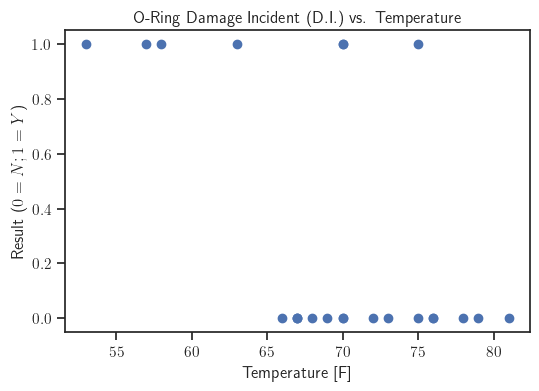

In [48]:
# visualizing the data
fig, ax = plt.subplots()
ax.plot(x, y, 'o')
ax.set_xlabel('Temperature [F]')
ax.set_ylabel('Result ($0=N; 1=Y$)')
ax.set_title("O-Ring Damage Incident (D.I.) vs. Temperature");
# reference(s): hands-on activity 16.1

In [49]:
# read-in necessary item from sklearn package
from sklearn.linear_model import LogisticRegression
# generate design matrix
X = np.hstack(
    [
        np.ones((x.shape[0], 1)),
        x[:, None]
    ]
)
# train the model
model = LogisticRegression(
    penalty='none',
    fit_intercept=False
).fit(X, y)
# extracting and displaying the coefficients
coeffs = model.coef_
print(f"model weights [w_1, w_2]: {coeffs}")
# reference(s); hands-on activity 16.1

model weights [w_1, w_2]: [[15.043 -0.232]]


We can use the values for the calculated weights and the expression below to investigate the correlation between temperature and probability of a damage incident:

$$
p(y=1|\mathbf{x},\mathbf{w}) =   \operatorname{sigm}\left(w_{1} + w_{2}x\right)
$$

The variables are negatively correlated because $w_{2}$ is negative.

## Part B - Plot the probability of damage as a function of temperature
Plot the probability of damage as a function of temperature.

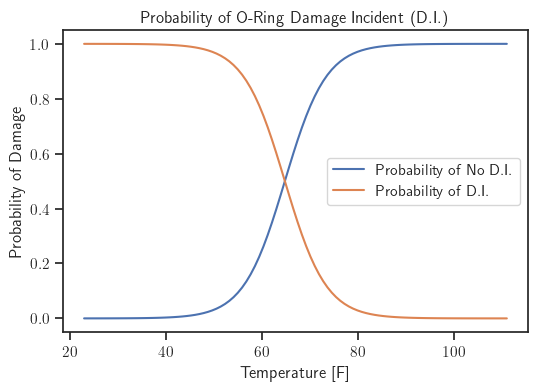

In [50]:
fig, ax = plt.subplots()
# generate temperature values
xx = np.linspace(x.min()-30, x.max()+30, 100)
# generate design matrix for temperature values
XX = np.hstack([np.ones((xx.shape[0], 1)), xx[:, None]])
# make prediction with model at all temperature values
predictions_xx = model.predict_proba(XX)
# plot & label
ax.plot(
    xx,
    predictions_xx[:, 0],
    label='Probability of No D.I.'
)
ax.plot(
    xx,
    predictions_xx[:, 1],
    label='Probability of D.I.'
)
ax.set_xlabel('Temperature [F]')
ax.set_ylabel('Probability of Damage')
ax.set_title("Probability of O-Ring Damage Incident (D.I.)")
plt.legend(loc='best');
# reference(s); hands-on activity 16.1

## Part C - Decide whether or not to launch

The temperature the day of the Challenger accident was 31 degrees F.
Start by calculating the probability of damage at 31 degrees F.
Then, use formal decision-making (i.e., define a cost matrix and make decisions by minimizing the expected loss) to decide whether or not to launch on that day.
Also, plot your optimal decision as a function of the external temperature.

In [51]:
# Use the model to predict the probability of a damage incident the morning Challenger launched
# Challenger data point
x_challenger = 31
# generating new design matrix for this single sample
Phi_challenger = np.array([1, x_challenger]).reshape(1, -1)
# making prediction with model and displaying
prob_challenger_damage = model.predict_proba(Phi_challenger)[0, 1]
print(f"Probability of O-Ring Damage Incident at {x_challenger} Degrees F is {prob_challenger_damage*100:0.2f}%.")

Probability of O-Ring Damage Incident at 31 Degrees F is 99.96%.


The next step is to generate a cost matrix to help with the decision. For the section below, we will define the following implications:

+ Picking no damage incident (D.I.) --> choose to launch
+ Picking damage incident (D.I.) --> choose not to launch

The below values for various costs are a combination of researched numbers and personal estimations. Links are provided, when possible, if the value was referenced from an external source.

In [52]:
# Cost of launching the mission
# https://en.wikipedia.org/wiki/Space_Shuttle_program
launch_cost = 450e6

# value of a statistical life (VSL)
# https://en.wikipedia.org/wiki/Value_of_life
VSL = 7.5e6

# cost of physical shuttle
# https://www.planetary.org/space-policy/sts-program-development-cost
vehicle_cost = 49e9

# https://www.space.com/6991-5-shuttle-launch-scrubs-cost-millions.html
scrub_costs = 1.2e6

# costs from accident (shuttle system modifications, resulting investigation, etc.)
# Source: "Budget Effects of the Challenger Accident", Staff Working Paper,
# March 1986, The Congress of the United States, Congressional Budget Office
accident_costs = 690e6

# material search and recovery (sr) costs
# https://www.spacesafetymagazine.com/space-disasters/challenger-disaster/
sr_costs = 13.1e6

# political costs & non-monetary implicatins, future budget risks (pnmifbr)
pnmifbr_costs = 5e9

# number of crew members
num_crew = 7

# construct cost matrix elements
# c_00 = cost of correctly picking No D.I. (launch) when No D.I. is true
c_00 = launch_cost
# c_01 = cost of wrongly picking No D.I. (launch) when D.I. is true
c_01 = launch_cost\
        + VSL*num_crew\
        + vehicle_cost\
        + accident_costs\
        + sr_costs
# c_11 = cost of correctly picking D.I (no launch) when D.I. is true
c_11 = scrub_costs
# c_10 = cost of wrongly picking D.I. (no launch) when No D.I. is true
c_10 = scrub_costs + pnmifbr_costs
# populate cost matrix
cost_matrix = np.array(
    [
        [c_00, c_01],
        [c_10, c_11]
    ]
)
print("Cost Matrix (in $): ")
print(cost_matrix)
# reference(s); hands-on activity 16.3

Cost Matrix (in $): 
[[4.500e+08 5.021e+10]
 [5.001e+09 1.200e+06]]


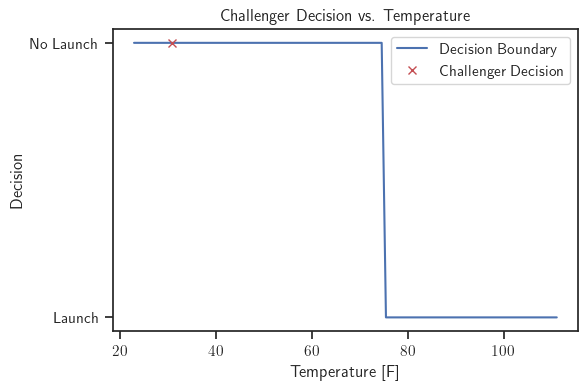

In [53]:
# plotting the best decision as a function of temperature
fig, ax = plt.subplots()
# calculate expected cost
exp_cost = np.einsum('ij,kj->ki', cost_matrix, predictions_xx)
# make decision at each temperature that minimizes the cost
decision_idx = np.argmin(exp_cost, axis=1)

# plot the decision boundary at all temperatures
ax.plot(xx, decision_idx, label="Decision Boundary")

# make & plot decision corresponding to the Challenger data point
challenger_predictions = model.predict_proba(Phi_challenger)
challenger_exp_cost = np.einsum('ij,kj->ki', cost_matrix, challenger_predictions)
challenger_decision = np.argmin(challenger_exp_cost, axis=1)
ax.plot(x_challenger, challenger_decision, 'rx', label="Challenger Decision")

# labels
ax.set_yticks([0, 1])
ax.set_yticklabels(['Launch', 'No Launch'])
ax.set_ylabel('Decision')
ax.set_xlabel('Temperature [F]')
ax.set_title("Challenger Decision vs. Temperature")
plt.legend(loc='best');
# reference(s); hands-on activity 16.3

**Part C Discussion:**

Based on the estimated costs associated with different model predicion outcomes and the above decision boundary plot, the choice should have been to *not launch* on the day that Challenger crashed. Temperatures were low and the probability of an O-Ring damage incident was high, and this statement aligns with our negative correlation observation about the model from previously. The decision corresponding to the temperature on the morning that Challenger launched is displayed in the above decision boundary plot as a red 'x'.